In [1]:
import pandas as pd
import ipywidgets as w
from IPython.display import display, IFrame
import pyspark
from pyspark.sql import SQLContext, functions, types
from pyspark.sql import Row
import matplotlib.pyplot as plt
from hotel_recc import *
%matplotlib inline

In [3]:
sc=pyspark.SparkContext(appName="hotel_recc")
spark = SQLContext(sc)

## User details and Preferences

In [4]:
## Ipywidgets to get user name and destination
name = w.Text(description="User Name")
place = w.Text(description="Destination")
v1 = w.VBox([name,place])

## Ipywidgets to get start and end date of the trip

start = w.DatePicker(description='Start Date',disabled=False)
end = w.DatePicker(description='End Date',disabled=False)
v2 = w.VBox([start,end])

out = w.HBox([v1,v2])
display(out)

In [5]:
## Reading file containing hotel details after removing duplicates
del_dup = spark.read.json('etl/del_dup')

## Reading file containing hotel details after removing duplicates and exploding amenities
newh_df = spark.read.json('etl/newh_df')

del_dup.createOrReplaceTempView('del_dup')
newh_df.createOrReplaceTempView('newh_df')

In [6]:
## Finding top 15 amentities to ask users to select inorder to provide hotel recommendations based on amenities chosen
newh1_df  = spark.sql("SELECT amenities,COUNT(amenities) AS tot_count FROM newh_df GROUP BY amenities ORDER BY tot_count DESC")
top_amenities = [x[0] for x in newh1_df.head(16) if x[0] != '']

## Getting user's amenity preferences
amenities_pref = []
def on_button_clicked(b):
    if b.description in amenities_pref:
        return
    print(b.description)
    amenities_pref.append(b.description)
    if(len(amenities_pref) < 5):
        print("Select {x} more!\n".format(x=5-len(amenities_pref)))
        
but_layout = w.Layout(width='100%', height='100px')
but_items = [w.Button(description=c, layout=but_layout) for c in top_amenities]
on_clk = [item.on_click(on_button_clicked) for item in but_items]
r1 = w.VBox([i for i in but_items[:5]])
r2 = w.VBox([i for i in but_items[5:10]])
r3 = w.VBox([i for i in but_items[10:]])
buttons = w.HBox([r1,r2,r3])
print("Select atleast 5 amenities:")
display(buttons)

Select atleast 5 amenities:


 Nonsmoking hotel
Select 4 more!

 Family Rooms
Select 3 more!

 Public Wifi
Select 2 more!

 Pets Allowed  Dog  Pet Friendly 
Select 1 more!

 Air conditioning


## Model training and evaluation

best rank :  12
best RMSE:3.08025294004643


<BarContainer object of 3 artists>

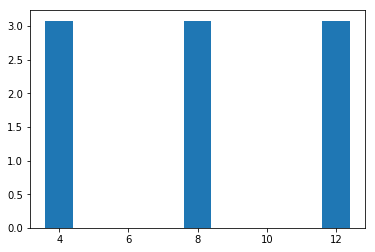

In [7]:
usr_rating = amenities_rating(spark, amenities_pref, newh_df)
rank, error, errors, usrid_s2 = model_train(spark, usr_rating)
print("best rank : ",rank)
print("best RMSE:" +str(error))
plt.bar([4,8,12], height=errors)

## Getting Recommendation

In [8]:
u_tempdf = get_hotel_recc(spark, usrid_s2)
hotel_df = del_dup.join(u_tempdf, "id").withColumn("address",functions.lower(functions.col("address")))
user_location = place.value.lower()
hotel_sugg = hotel_df.where(hotel_df.address.contains(user_location))
recc = hotel_sugg.dropna().toPandas()

In [9]:
%%capture
final = dict()
final['address'] = recc[:5]['address'].values.tolist()
final['amenities'] = recc[:5]['amenities'].values.T.tolist()
final['experience'] = recc[:5]['hotel_experience'].values.tolist()
final['name'] = recc[:5]['hotel_name'].values.tolist()
final['rating'] = recc[:5]['hotel_rating'].values.tolist()
final['location'] = [i[1:-1] for i in recc[:5]['location'].values.tolist()]
final['price'] = recc[:5]['price'].values.tolist()
final['image'] = [get_image(i) for i in recc[:5]['hotel_name'].values.tolist()]

## Final Output

In [10]:
days = (end.value - start.value).days
tab_recc = get_hotel_output(days, final)
display(tab_recc)